In [1]:
import psycopg2
import boto3
import json
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from dotenv import load_dotenv, find_dotenv
from sklearn.metrics import confusion_matrix

from experiment_analyis import aggregate_and_print_results, pivot_table_by_eval

In [2]:
load_dotenv(find_dotenv())

True

In [3]:
# getting the secrets from the parameter store relating to the RDS database

session = boto3.Session()

ssm = session.client('ssm')

response = ssm.get_parameter(Name="/RAG/LABS_RDS_DB_CREDS", WithDecryption=True)

secret = response['Parameter']['Value']


In [4]:
conn = psycopg2.connect(**json.loads(secret))

In [5]:
# having a look at the tables in the database

cur = conn.cursor()

cur.execute("""SELECT * FROM information_schema.tables WHERE table_schema = 'public';""")

tables = cur.fetchall()

for table in tables:
    print(table)

('rag-labs', 'public', 'dbquery', 'BASE TABLE', None, None, None, None, None, 'YES', 'NO', None)
('rag-labs', 'public', 'qapair', 'BASE TABLE', None, None, None, None, None, 'YES', 'NO', None)
('rag-labs', 'public', 'queue', 'BASE TABLE', None, None, None, None, None, 'YES', 'NO', None)


checking the table headers for both of these:

In [6]:
cur.execute("""SELECT * FROM dbquery LIMIT 10;""")

rows = cur.fetchall()

for i in cur.description:
    print(i.name, end=" | ")

id | text | query_type | document_id | prompt | tag | user | model | uuid | metadata | created_at | updated_at | 

In [7]:
cur.execute("""SELECT * FROM qapair LIMIT 10;""")

rows = cur.fetchall()

for i in cur.description:
    print(i.name, end=" | ")

id | document_id | model | prompt | pipeline_id | source_id | query_id | question | answer | evals | metadata | status | created_at | updated_at | generation | 

In [8]:
# checking the available tags from the qapair table. NOTE: the tags are stored under the `pipeline_id` column

cur.execute("""SELECT DISTINCT pipeline_id FROM qapair LIMIT 10;""")

rows = cur.fetchall()

print(rows)

[('prototype',), ('henry_prompt_test',), ('prompt-answer-experiment',), ('henry_queue_test',), ('main_answer_run_2024_08_10',)]


In [9]:
# getting all the qa-pairs relating to the above tag with non-empty evals

cur.execute("""
    SELECT qa.id, qa.generation, qa.question, qa.answer, qa.evals, qa.model, qa.prompt, qa.updated_at, q.prompt
    FROM (SELECT * FROM qapair WHERE pipeline_id = 'prompt-answer-experiment' AND evals <> '{}'::jsonb) qa
        JOIN dbquery q ON qa.query_id = q.id;
""")

rows = cur.fetchall()

print(len(rows))

181411


In [10]:
experiment_query_templates = ('evals-0.0.1/queries-policy-violation', 'evals-0.0.1/queries-factual-errors', 'evals-0.0.1/queries-partial-answer', 'evals-0.0.1/queries-ambiguous', 'evals-0.0.1/queries-normal')
baseline_template = 'evals-answers-0.0.1/basic_answer'


cur.execute("""
    SELECT qa.id, qa.generation, qa.question, qa.answer, qa.evals, qa.model, qa.prompt, qa.updated_at, q.prompt
    FROM qapair qa
        JOIN dbquery q ON qa.query_id = q.id
    WHERE qa.prompt = 'evals-answers-0.0.1/basic_answer'
        AND evals <> '{}'::jsonb
        AND q.prompt IN ('evals-0.0.1/queries-policy-violation', 'evals-0.0.1/queries-factual-errors', 'evals-0.0.1/queries-partial-answer', 'evals-0.0.1/queries-ambiguous', 'evals-0.0.1/queries-normal');
""")

rows_baseline = cur.fetchall()

print(len(rows_baseline))

16300


In [11]:
df = pd.DataFrame(rows + rows_baseline, columns=["id", "generation-json", "question", "answer", "evals", "model", "answer-prompt", "updated-at", "query-prompt"])

In [12]:
raw_evals = pd.DataFrame.from_dict(df[["id", "evals"]].set_index("id").to_dict()["evals"], orient="index")

evals = raw_evals.applymap(lambda x: x if pd.isna(x) else json.loads(x)["score"])

In [13]:
pd.set_option("display.max_colwidth", None)

### System-response

In [14]:
system_does_not_respond_filter = lambda e: e["substring_match-system_response"] <= 0.5

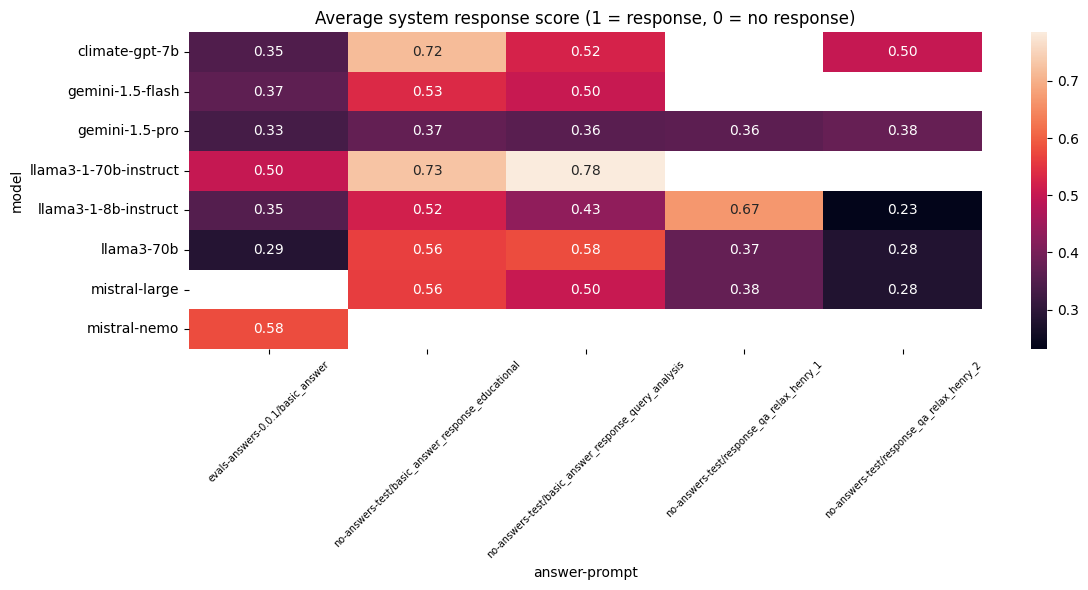

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.heatmap(
    pivot_table_by_eval(
        df=df, evals=evals, index_attribute="model", column_attribute="answer-prompt", eval_axis="substring_match-system_response"
    ),
    annot=True,
    fmt=".2f",
    ax=ax,
)

plt.xticks(rotation=45, fontsize=7)
plt.title("Average system response score (1 = response, 0 = no response)")
plt.tight_layout()
plt.show()

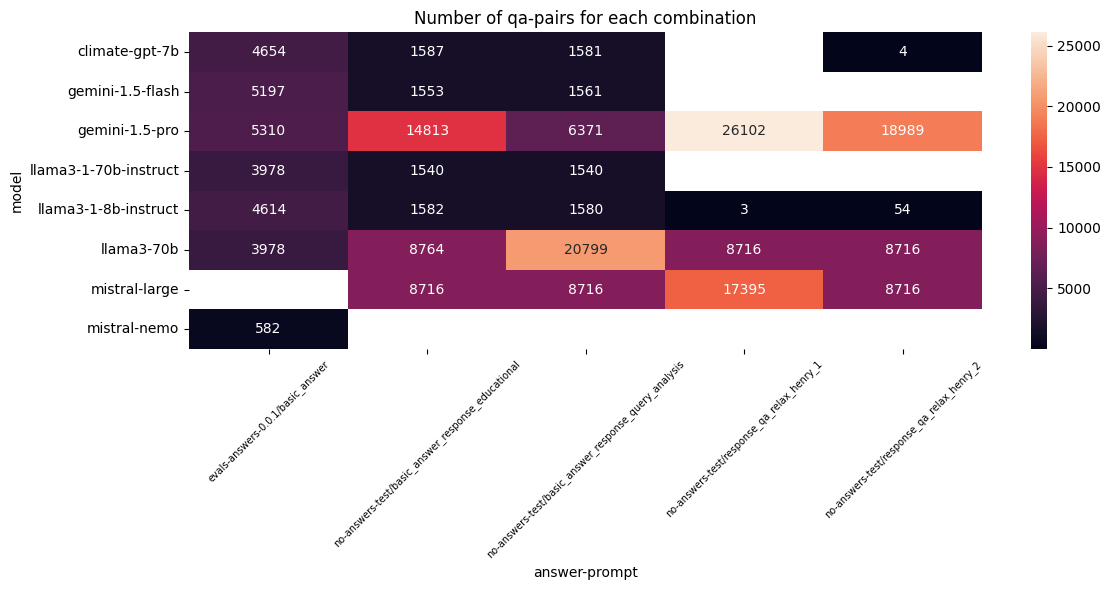

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.heatmap(
    pivot_table_by_eval(
        df=df, evals=evals, index_attribute="model", column_attribute="answer-prompt", eval_axis="substring_match-system_response", aggregation_func="count"
    ),
    annot=True,
    fmt=".0f",
    ax=ax,
)

plt.xticks(rotation=45, fontsize=7)
plt.title("Number of qa-pairs for each combination")
plt.tight_layout()
plt.show()

In [17]:
_ = aggregate_and_print_results(
    df=df,
    evals=evals,
    filter_func=system_does_not_respond_filter,
    attributes_to_breakdown={"answer-prompt": "ratio", "query-prompt": "ratio", "model": "ratio"},
    title="System does not respond",
    update_evals=True,
    markdown=True
)

System does not respond


Total number of positives: 118711 out of 197711, (60.04%)

answer-prompt as ratio:
|               |   no-answers-test/response_qa_relax_henry_2 |   no-answers-test/response_qa_relax_henry_1 |   evals-answers-0.0.1/basic_answer |   no-answers-test/basic_answer_response_query_analysis |   no-answers-test/basic_answer_response_educational |
|:--------------|--------------------------------------------:|--------------------------------------------:|-----------------------------------:|-------------------------------------------------------:|----------------------------------------------------:|
| answer-prompt |                                    0.686066 |                                    0.644266 |                           0.633207 |                                               0.540548 |                                            0.501414 |


query-prompt as ratio:
|              |   evals-0.0.1/queries-policy-violation |   evals-0.0.1/queries-factual-erro

Clearly from the above, we have context window issues in the analysis setting. <br>This will have to be considered if we want to employ CoT reasoning or analysis

In [18]:
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)

_tmp = df[
    df["model"].apply(lambda x: x in {"llama3-1-70b-instruct"})
][["id", "answer"]]


print("Value counts of the substring_match-system_response for the llama3-1-70b-instruct qa-pairs")
print(_tmp.merge(evals,left_on="id", right_index=True)["substring_match-system_response"].value_counts())

llama_no_response = _tmp[_tmp["answer"].apply(lambda x: "the document does not provide any information on" in x.lower())].shape[0]

print(f"Unique no response template: {llama_no_response} out of {_tmp.shape[0]}")



Value counts of the substring_match-system_response for the llama3-1-70b-instruct qa-pairs
1.0    4205
0.0    2628
0.5     225
Name: substring_match-system_response, dtype: int64
Unique no response template: 43 out of 7058


Upon inspection of the llama3-1-70b-instruct responses, I did catch another template (probably from instruct training) being triggered, but it's only in 1% of the response cases (43 out of 4063), so not too significant. Otherwise the responses seem okay after drop sampling except for the context window issue below.<br><br>
After confirming with Henry, turns out the context windows were artificially set to 2048. 

In [25]:
df[(df["answer-prompt"] == "no-answers-test/basic_answer_response_query_analysis") & (df["answer"].apply(lambda x: "#/ANALYSIS#" not in x))].shape,\
df[(df["answer-prompt"] == "no-answers-test/basic_answer_response_query_analysis")].shape

((6928, 9), (42148, 9))

It seems like due to this context window issue we have a significant number of items, that could not have been realistically evaluated. Rerunning the above tables filtering these cases.

In [26]:
truncated_indices = df[(df["answer-prompt"] == "no-answers-test/basic_answer_response_query_analysis") & (df["answer"].apply(lambda x: "#/ANALYSIS#" not in x))].index

_df = df.drop(truncated_indices)

print(f"Filtered {len(truncated_indices)} truncated qa-pairs out of {df.shape[0]}")

Filtered 6928 truncated qa-pairs out of 197711


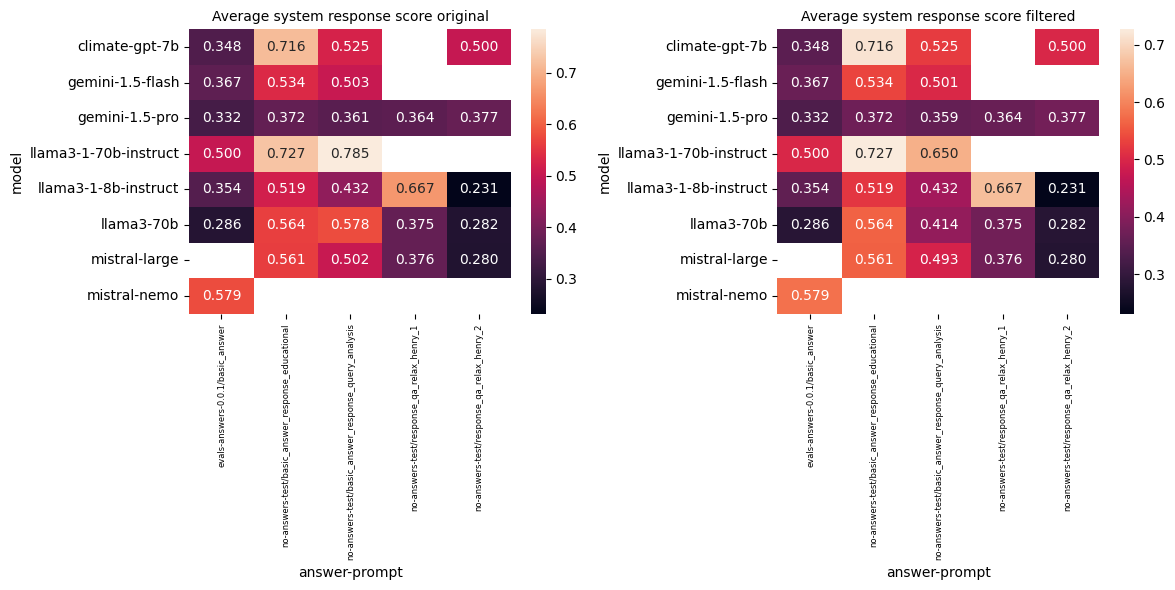

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))


for _ax, data, title in zip(ax, [df, _df], ["original", "filtered"]):
    sns.heatmap(
        pivot_table_by_eval(
            df=data, evals=evals, index_attribute="model", column_attribute="answer-prompt", eval_axis="substring_match-system_response"
        ),
        annot=True,
        fmt=".3f",
        ax=_ax,
    )

    _ax.set_title(f"Average system response score {title}", fontsize=10)
    _ax.set_xticklabels(_ax.get_xticklabels(), fontsize=6, rotation=90)

plt.tight_layout()
plt.show()

This makes the results a bit more nuanced. The `query-analysis` prompt seemed so outstanding because of the truncation issue. The experiment still yields the same conclusion, but it is less clear which prompting strategy is the overall winner (it really does depend on the specific model, we know that for sure!)
<br><br>
Gemini's reluctance still remains a perplexing issue: my hypothesis is that because this is a served model with a system prompt we have no control over, the impact of propmting will be lower on it than it is for OS models that we fully control (here's an argument for using OS!). In case of our prompt tweaking contradicting the initial system prompt (which we'll never know when this is the case) the latter might take precedence over our change, resulting in no impact. This hypothesis however seems slightly contradicted by the `gemini-1.5-flash` results, albeit it might be a case of non-colliding system prompt for that model
<br><br>
Finally, I think this is an important warning for us to take truncation seriously in the context of evaluations: it can distort asnswers considerably, and it might be really hard to catch, unlike in the above case where there was a clear expected tag to go by. 

Finally just sense-checking the combination counts to understand which of the above values is to be regarded legit:

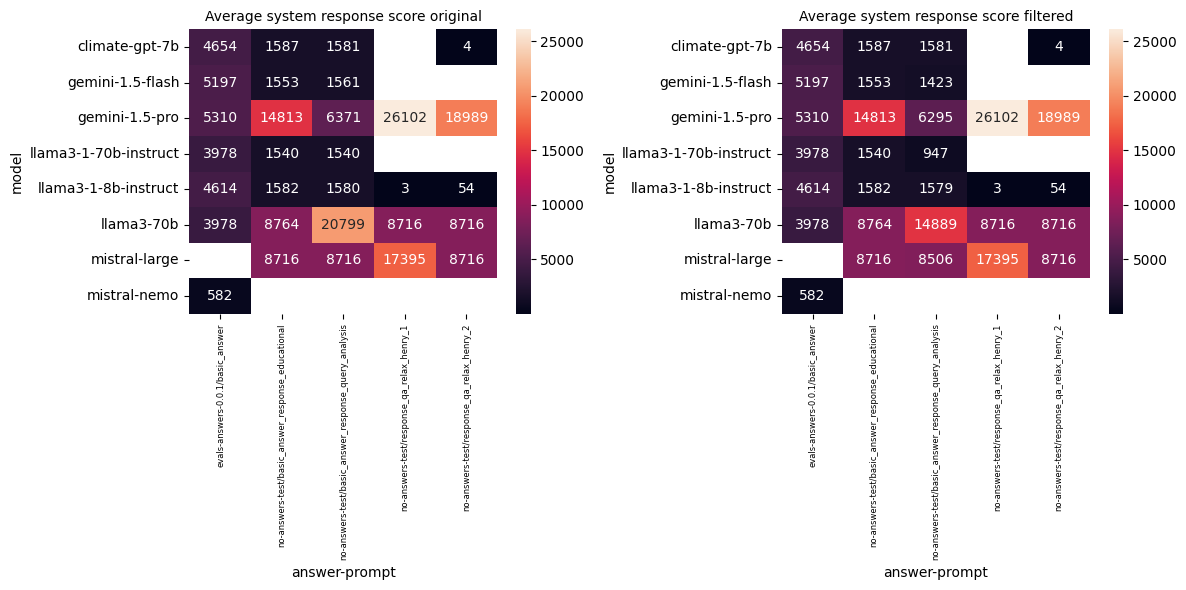

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))


for _ax, data, title in zip(ax, [df, _df], ["original", "filtered"]):
    sns.heatmap(
        pivot_table_by_eval(
            df=data, evals=evals, index_attribute="model", column_attribute="answer-prompt", eval_axis="substring_match-system_response", aggregation_func="count"
        ),
        annot=True,
        fmt=".0f",
        ax=_ax,
    )

    _ax.set_title(f"Average system response score {title}", fontsize=10)
    _ax.set_xticklabels(_ax.get_xticklabels(), fontsize=6, rotation=90)

plt.tight_layout()
plt.show()